# 모델3 : 강철판

## 모델구성
- 김동현님 모델

In [1]:
# Tensorflow Check
import tensorflow as tf
from tensorflow.python.client import device_lib
import sys
print(f'Python     : {sys.version.split("|")[0]}')
print(f'Tensorflow : {tf.__version__}')
print(f'TF GPU     : {"True" if device_lib.list_local_devices()[1] else "False"}')

Python     : 3.10.11 
Tensorflow : 2.10.1
TF GPU     : True


In [2]:
# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score

from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers

from IPython.display import clear_output
import json

# 각종 변수 선언
csv_path = 'D:/coding/aib/GPTeachersDay/TeamProject1/leeyeonjun/Data/mulit_classification_data.csv'
EPOCHS = 300
MB_SIZE = 2048

In [3]:
# 필요한 함수 / 메소드 정의
class CustomCallback(keras.callbacks.Callback):
    """
    사용자 정의 콜백함수
    """
    def on_train_begin(self, logs=None):
        print("Starting training")

    def on_train_end(self, logs=None):
        print("End training")
        # clear_output(wait=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:print()
        if epoch % 10 == 0:
            print(f'{epoch} / ', end='')

def load_data(csv_path, TRAIN_RATIO=0.8):
    global X, y, X_train, X_test, y_train, y_test, df, encoder
    
        # 데이터셋 로드
    df = pd.read_csv(csv_path)
    
    # 인코딩 방식 변경
    # idxmax 함수는 각 행의 최대값을 가진 열의 인덱스를 반환한다. 따라서 원핫인코딩된 피쳐를 하나의 카테고리 변수로 복원할 수 있음
    df['Fault'] = df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']].idxmax(axis=1)
    
    # 라벨 인코딩(원핫인코딩보다 차원수가 줄어드는 효과)
    encoder = LabelEncoder()
    df['Fault'] = encoder.fit_transform(df['Fault'])
    
    # 학습 데이터 분리
    X = df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults', 'Fault'], axis=1)
    y = df['Fault']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_RATIO, random_state = 83)
    
    # 스케일링할 피처 선택
    scaling_features = X_train.columns

    # 스케일링
    scaler = MinMaxScaler()
    X_train_org = X_train.copy()  # 원본 데이터 복사
    X_test_org = X_test.copy()    # 원본 데이터 복사
    X_train[scaling_features] = scaler.fit_transform(X_train[scaling_features])
    X_test[scaling_features] = scaler.transform(X_test[scaling_features])

def get_model(units, l2):
    
    np.random.seed(83)
    tf.random.set_seed(83)
    
    inputs = Input(shape=(len(X_train.keys()),))
    x = Dense(units=units[0], activation='relu', kernel_regularizer=regularizers.l2(l2[0]))(inputs)
    x = Dropout(0.2)(x)

    for i in range(1, 8):   
        dense = Dense(units=units[i], activation='relu', kernel_regularizer=regularizers.l2(l2[i]))
        y = dense(x)
        y = Dropout(0.2)(y)
        x = Add()([x, y])

    outputs = Dense(units=7, activation='softmax')(x) # 출력 유닛의 수를 클래스 수에 맞추고, softmax 활성화 함수를 사용

    model = Model(inputs=inputs, outputs=outputs)
    
    # 옵티마이저와 손실 함수 설정
    optimizer = tf.keras.optimizers.Adam(
                                        learning_rate=0.001,
                                        beta_1=0.9,
                                        beta_2=0.999,
                                        epsilon=1e-08
                                        )

    model.compile(loss='sparse_categorical_crossentropy',  # 손실함수를 다중 클래스 분류에 적합한 형태로 변경
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model

In [4]:
load_data(csv_path)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X_train.describe()

(1552, 27) (389, 27) (1552,) (389,)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,...,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000,1552.000000
mean,0.330774,0.356441,0.126574,0.126577,0.013108,0.011009,0.004751,0.018771,0.428144,0.432948,...,0.037632,0.597720,0.797034,0.575709,0.393919,0.336539,0.281349,0.539658,0.544567,0.535582
std,0.305080,0.290613,0.135898,0.135898,0.036294,0.031247,0.026128,0.046750,0.162898,0.084864,...,0.071875,0.246366,0.248450,0.483349,0.180612,0.187544,0.115831,0.255834,0.091082,0.389066
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029326,0.110445,0.036023,0.036025,0.000524,0.001149,0.000661,0.000781,0.316327,0.404651,...,0.005036,0.391234,0.567255,0.000000,0.262467,0.201348,0.196629,0.315832,0.505753,0.145342
50%,0.233138,0.258046,0.092082,0.092089,0.001127,0.002393,0.001322,0.001637,0.459184,0.418605,...,0.009271,0.624188,0.936318,1.000000,0.334173,0.269157,0.263133,0.549957,0.544606,0.461662
75%,0.615249,0.621416,0.168545,0.168544,0.006124,0.008711,0.004683,0.007855,0.540816,0.479070,...,0.025295,0.797078,1.000000,1.000000,0.498303,0.410859,0.367613,0.759444,0.586540,0.999886
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# 스케일링할 피처 선택
scaling_features = X_train.columns

# 스케일링
scaler = MinMaxScaler()
X_train_org = X_train.copy()  # 원본 데이터 복사
X_test_org = X_test.copy()    # 원본 데이터 복사
X_train[scaling_features] = scaler.fit_transform(X_train[scaling_features])
X_test[scaling_features] = scaler.transform(X_test[scaling_features])

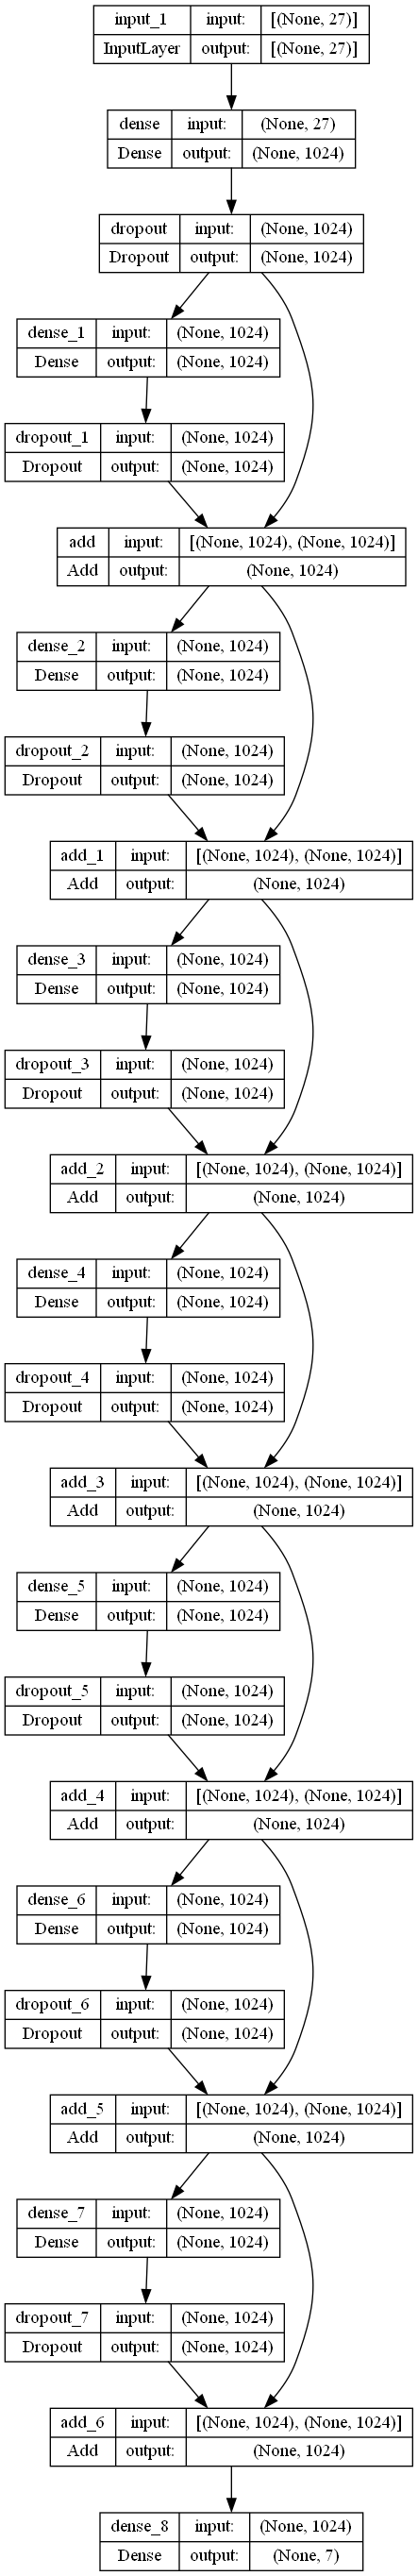

In [6]:
# 모델 객체 생성
"""
units = [33, 64, 128, 256, 256, 128, 64, 33]
L2 = [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
model = Classifier_Model(units, L2)
"""
units = [1024 for _ in range(8)]
L2_p = [0.001 + i * 0.0025 for i in range(8)]
model = get_model(units, L2_p)
keras.utils.plot_model(model, show_shapes=True, to_file='model3_model.png')

In [15]:
print(X_train.shape)
print(y_train.shape)

(1552, 27)
(1552,)


In [16]:
# 얼리스타핑
# es = EarlyStopping(monitor='loss', patience=50, mode='auto')

# 모델 저장
checkpoint_path = './model3.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
                                        checkpoint_path
                                        , monitor='loss'
                                        , verbose=0
                                        , mode = 'auto'
                                        , save_best_only=True
                                        , save_weights_only=True)

# 학습률 조정
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=20, mode='auto')

# 모델 학습
history = model.fit(X_train, y_train
                , batch_size=MB_SIZE
                , validation_split = 0.2
                , verbose=0
                , epochs=EPOCHS
                , callbacks=[checkpoint, CustomCallback(), rlrp]
                )

Starting training

0 / 10 / 20 / 30 / 40 / 50 / 60 / 70 / 80 / 90 / 
100 / 110 / 120 / 130 / 140 / 150 / 160 / 170 / 180 / 190 / 
200 / 210 / 220 / 230 / 240 / 250 / 260 / 270 / 280 / 290 / End training


In [23]:
# 가장 성능이 좋았던 모델을 가져와 평가
model.load_weights(checkpoint_path)
results = model.evaluate(X_test, y_test)
print(f'Test Loss : {results[0]:.3f} / Accuracy: {results[1]:.3f} ')

13/13 [==============================] - 0s 15ms/step - loss: 1.1904 - accuracy: 0.7532
Test Loss : 1.190 / Accuracy: 0.753 


In [24]:
import json
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist = hist.set_index('epoch')
hist.to_json('model3.json')

In [30]:
with open('model3.json') as json_file:
    json_file = json.loads(json_file.read())
model3_hist = pd.DataFrame(json_file)
model3_hist

,loss,accuracy,val_loss,val_accuracy,lr
0,82.058937,0.164384,91.637733,0.324759,0.001
1,92.988396,0.346495,84.931625,0.221865,0.001
2,86.373833,0.198227,77.636223,0.279743,0.001
3,78.185234,0.238517,74.767197,0.086817,0.001
4,75.024757,0.103948,72.513588,0.180064,0.001
...,...,...,...,...,...
295,0.923681,0.846898,1.228266,0.762058,0.001
296,0.924513,0.854150,1.231784,0.762058,0.001
297,0.921703,0.850927,1.247968,0.755627,0.001
298,0.915258,0.845286,1.221015,0.752412,0.001


In [31]:
model3_hist.sort_values(by=['val_loss'], ascending=True).iloc[:5,:]

,loss,accuracy,val_loss,val_accuracy,lr
298,0.915258,0.845286,1.221015,0.752412,0.001
295,0.923681,0.846898,1.228266,0.762058,0.001
293,0.932745,0.850121,1.229056,0.765273,0.001
296,0.924513,0.854150,1.231784,0.762058,0.001
291,0.957041,0.830782,1.244908,0.762058,0.001


13/13 [==============================] - 0s 7ms/step


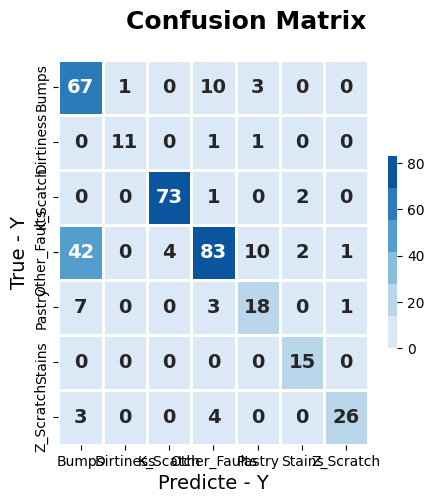

In [27]:
c_mat = confusion_matrix(y_test, tf.math.argmax(model.predict(X_test), axis=1))

# 히트맵을 그린다
fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Confusion Matrix', fontsize = 18, fontweight = 'bold')
sns.heatmap(c_mat, 
            cmap = sns.color_palette('Blues'), 
            annot = True,
            annot_kws = {'fontweight':'bold','size':14},
            fmt=',.0f',
            linewidths = 2,
            cbar_kws = {'shrink': .5},
           )

ax.xaxis.set_ticklabels(encoder.classes_)
ax.yaxis.set_ticklabels(encoder.classes_)
plt.xlabel('Predicte - Y', fontsize = 14)
plt.ylabel('True - Y', fontsize = 14)
plt.show()

fig.savefig('model3_cm.png', dpi=80, bbox_inches='tight')

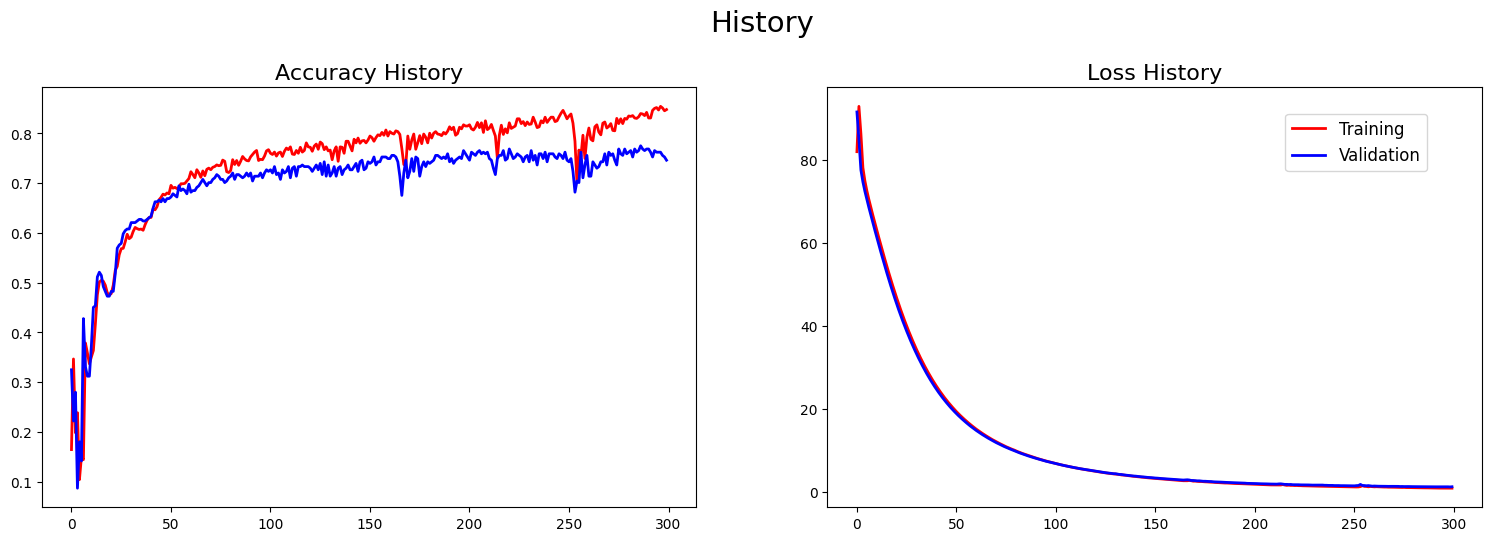

In [28]:
fig = plt.figure(figsize=(16, 6))
fig.suptitle('History', fontsize = 21)

# Accuracy Plot
ax = plt.subplot(1, 2, 1)
plt.title(f'Accuracy History', fontsize = 16, y = 1)
plt.plot(history.history["accuracy"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_accuracy"], color='b', linewidth=2, label="Validation")

# Loss Plot
ax = plt.subplot(1, 2, 2)
plt.title(f'Loss History', fontsize = 16, y = 1)
plt.plot(history.history["loss"], color='r', linewidth=2, label="Training")
plt.plot(history.history["val_loss"], color='b', linewidth=2, label="Validation")

plt.legend(fontsize=12, loc=(0.7, 0.8))
plt.subplots_adjust(right=0.95, left=0.05, top=0.85, bottom=0.15, wspace=0.2, hspace=0.2)
plt.show()

fig.savefig('model3_history.png', dpi=80, bbox_inches='tight')